In [98]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy

from sklearn import svm, datasets
from sklearn.model_selection import cross_validate

from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 12, 4

In [99]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

# Convert string into dict
# 'belongs_to_collection'
dict_columns = ['genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
for dataset in full_data:
    for column in dict_columns:
        dataset[column] = dataset[column].apply(lambda x: [] if x!=x else ast.literal_eval(x)) # x!=x means x is nan

In [100]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [101]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      0
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies        0
production_countries        0
release_date                0
runtime                     2
spoken_languages            0
status                      0
tagline                   597
title                       0
Keywords                    0
cast                        0
crew                        0
revenue                     0
dtype: int64

## belongs_to_collection

In [102]:
for index, row in train['belongs_to_collection'][0:5].iteritems():
    print(index, row)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan


In [103]:
train['belongs_to_collection'].isnull().value_counts()

True     2396
False     604
Name: belongs_to_collection, dtype: int64

In [104]:
for dataset in full_data:
    dataset['HasCollection'] = dataset['belongs_to_collection'].apply(lambda x: 1 if x!=x else 0)
train.drop('belongs_to_collection', axis=1, inplace = True)
test.drop('belongs_to_collection', axis=1, inplace = True)
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,1


## genres
Note: This process may be able to use dummy node to expand the genres in the future!!!

In [105]:
for index, row in train['genres'][0:5].iteritems():
    print(index, row)
#train[train['genres'].isna()]
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [106]:
genre_list = train['genres'].apply(lambda x: [i['name'] for i in x])
genre_rank = pd.Series(genre_list.sum()).value_counts()
print(genre_rank)

for dataset in full_data:
    dataset['genres'] = dataset['genres'].apply(lambda x: [i['name'] for i in x])
    dataset['num_genres'] = dataset['genres'].apply(lambda x: len(x))
    for i in genre_rank.keys():
        dataset[i] = dataset['genres'].apply(lambda x: 1 if i in x else 0)
    dataset["all_genres"] = dataset['genres'].apply(lambda x: "_".join(x))


Drama              1531
Comedy             1028
Thriller            789
Action              741
Romance             571
Crime               469
Adventure           439
Horror              301
Science Fiction     290
Family              260
Fantasy             232
Mystery             225
Animation           141
History             132
Music               100
War                 100
Documentary          87
Western              43
Foreign              31
TV Movie              1
dtype: int64


In [107]:

all_genres_rank = train["all_genres"].value_counts()[0:30]

for dataset in full_data:
    for i in all_genres_rank.keys():
        dataset['all_genres_'+i] = dataset['all_genres'].apply(lambda x: 1 if i in x else 0)


In [108]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,all_genres,all_genres_Drama,all_genres_Comedy,all_genres_Drama_Romance,all_genres_Comedy_Romance,all_genres_Comedy_Drama,all_genres_Comedy_Drama_Romance,all_genres_Horror_Thriller,all_genres_Documentary,all_genres_Drama_Thriller,all_genres_Crime_Drama_Thriller,all_genres_Horror,all_genres_Crime_Drama,all_genres_Action_Comedy,all_genres_Drama_Comedy,all_genres_Action_Thriller,all_genres_Drama_History,all_genres_Action_Crime_Thriller,all_genres_Action_Drama_Thriller,all_genres_Comedy_Crime,all_genres_Drama_Comedy_Romance,all_genres_Action_Crime_Drama_Thriller,all_genres_Romance_Drama,all_genres_Comedy_Family,all_genres_Action,all_genres_Thriller,all_genres_Drama_War,all_genres_Drama_Crime,all_genres_Horror_Mystery_Thriller,all_genres_Action_Comedy_Crime,all_genres_Crime_Drama_Mystery_Thriller
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Comedy_Drama_Family_Romance,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thriller_Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s.

## production_companies

In [109]:
for index, row in train['production_companies'][0:5].iteritems():
    print(index, row)
company_list = train['production_companies'].apply(lambda x: [i['name'] for i in x])
company_rank = pd.Series(company_list.sum()).value_counts()
print(company_rank[company_rank>30])
for dataset in full_data:
    dataset['production_companies'] = dataset['production_companies'].apply(lambda x: [i['name'] for i in x])
    dataset['num_companies'] = dataset['production_companies'].apply(lambda x:len(x))
train.head(3)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 []
4 []
Warner Bros.                              202
Universal Pictures                        188
Paramount Pictures                        161
Twentieth Century Fox Film Corporation    138
Columbia Pictures                          91
Metro-Goldwyn-Mayer (MGM)                  84
New Line Cinema                            75
Touchstone Pictures                        63
Walt Disney Pictures                       62
Columbia Pictures Corporation              61
TriStar Pictures                           53
Relativity Media                           48
Canal+                                     46
United Artists                             44
Miramax Films                       

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,all_genres,all_genres_Drama,all_genres_Comedy,all_genres_Drama_Romance,all_genres_Comedy_Romance,all_genres_Comedy_Drama,all_genres_Comedy_Drama_Romance,all_genres_Horror_Thriller,all_genres_Documentary,all_genres_Drama_Thriller,all_genres_Crime_Drama_Thriller,all_genres_Horror,all_genres_Crime_Drama,all_genres_Action_Comedy,all_genres_Drama_Comedy,all_genres_Action_Thriller,all_genres_Drama_History,all_genres_Action_Crime_Thriller,all_genres_Action_Drama_Thriller,all_genres_Comedy_Crime,all_genres_Drama_Comedy_Romance,all_genres_Action_Crime_Drama_Thriller,all_genres_Romance_Drama,all_genres_Comedy_Family,all_genres_Action,all_genres_Thriller,all_genres_Drama_War,all_genres_Drama_Crime,all_genres_Horror_Mystery_Thriller,all_genres_Action_Comedy_Crime,all_genres_Crime_Drama_Mystery_Thriller,num_companies
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Comedy_Drama_Family_Romance,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [110]:
for dataset in full_data:
    for i in company_rank.keys()[0:30]:
        dataset[i] = dataset['production_companies'].apply(lambda x: 1 if i in x else 0)
train.head(3)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,...,all_genres_Romance_Drama,all_genres_Comedy_Family,all_genres_Action,all_genres_Thriller,all_genres_Drama_War,all_genres_Drama_Crime,all_genres_Horror_Mystery_Thriller,all_genres_Action_Comedy_Crime,all_genres_Crime_Drama_Mystery_Thriller,num_companies,Warner Bros.,Universal Pictures,Paramount Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures,Metro-Goldwyn-Mayer (MGM),New Line Cinema,Touchstone Pictures,Walt Disney Pictures,Columbia Pictures Corporation,TriStar Pictures,Relativity Media,Canal+,United Artists,Miramax Films,Village Roadshow Pictures,Regency Enterprises,BBC Films,Working Title Films,Dune Entertainment,Fox Searchlight Pictures,Lionsgate,StudioCanal,DreamWorks SKG,Fox 2000 Pictures,Summit Entertainment,Hollywood Pictures,Orion Pictures,Dimension Films,Amblin Entertainment
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## production_countries

In [111]:
for index, row in train.production_countries[0:5].iteritems():
    print(index, row)
country_list = train['production_countries'].apply(lambda x: [i['name'] for i in x])
country_rank = pd.Series(country_list.sum()).value_counts()
print(country_rank[0:15])

for dataset in full_data:
    dataset['production_countries'] = dataset['production_countries'].apply(lambda x: [i['name'] for i in x])
    dataset['num_countries'] = dataset['production_countries'].apply(lambda x:len(x))
    for i in country_rank.keys()[0:30]:
        dataset[i] = dataset['production_countries'].apply(lambda x: 1 if i in x else 0)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
United States of America    2282
United Kingdom               380
France                       222
Germany                      167
Canada                       120
India                         81
Italy                         64
Japan                         61
Australia                     61
Russia                        58
Spain                         54
China                         42
Hong Kong                     42
Ireland                       23
Belgium                       23
dtype: int64


## spoken_languages

In [112]:
for index, row in train.spoken_languages[0:5].iteritems():
    print(index, row)

langauge_list = train['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x])
langauge_rank = pd.Series(langauge_list.sum()).value_counts()
print(langauge_rank[0:15])
for dataset in full_data:
    dataset['spoken_languages'] = dataset['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x])
    dataset['num_languages'] = dataset['spoken_languages'].apply(lambda x:len(x))
    for i in langauge_rank.keys()[0:30]:
        dataset[i] = dataset['spoken_languages'].apply(lambda x: 1 if i in x else 0)


0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
en    2618
fr     288
es     239
de     169
ru     152
it     124
ja      89
zh      68
hi      56
pt      43
ar      40
ko      37
cn      36
ta      27
pl      25
dtype: int64


In [113]:
langauge_rank

en    2618
fr     288
es     239
de     169
ru     152
it     124
ja      89
zh      68
hi      56
pt      43
ar      40
ko      37
cn      36
ta      27
pl      25
hu      24
la      23
th      22
sv      22
cs      20
he      15
el      15
da      13
tr      13
nl      10
fa      10
vi      10
yi       8
ro       8
ur       8
      ... 
bg       2
sk       2
eo       2
eu       2
mi       2
zu       2
mr       2
id       2
bo       2
hr       2
nv       1
sa       1
ln       1
kw       1
ku       1
sh       1
my       1
gu       1
wo       1
kk       1
qu       1
et       1
km       1
ny       1
lo       1
st       1
ps       1
am       1
si       1
xh       1
Length: 79, dtype: int64

## Keywords

In [114]:
for index, row in train['Keywords'][0:5].iteritems():
    print(index, row)
keyword_list = train['Keywords'].apply(lambda x: [i['name'] for i in x])
keyword_rank = pd.Series(keyword_list.sum()).value_counts()
print(keyword_rank[0:15])

for dataset in full_data:
    dataset['Keywords'] = dataset['Keywords'].apply(lambda x: [i['name'] for i in x])
    dataset['num_keywords'] = dataset['Keywords'].apply(lambda x:len(x))
    for i in keyword_rank.keys()[0:30]:
        dataset[i] = dataset['Keywords'].apply(lambda x: 1 if i in x else 0)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

## cast

In [115]:
#for index, row in train['cast'][0:1].iteritems():
#    print(index, row)

cast_name_list = train['cast'].apply(lambda x: [i['name'] for i in x])
cast_name_rank = pd.Series(cast_name_list.sum()).value_counts()
print(cast_name_rank[0:30])

cast_character_list = train['cast'].apply(lambda x: [i['character'] for i in x])
cast_character_rank = pd.Series(cast_character_list.sum()).value_counts()
print(cast_character_rank[0:30])

cast_gender_list = train['cast'].apply(lambda x: [i['gender'] for i in x])
cast_gender_rank = pd.Series(cast_gender_list.sum()).value_counts()
print(cast_gender_rank)

for dataset in full_data:
    dataset['cast_name'] = dataset['cast'].apply(lambda x: [i['name'] for i in x])
    dataset['cast_character'] = dataset['cast'].apply(lambda x: [i['character'] for i in x])
    dataset['cast_gender'] = dataset['cast'].apply(lambda x: [i['gender'] for i in x])
    
    dataset['num_cast'] = dataset['cast'].apply(lambda x:len(x))
    for i in cast_name_rank.keys()[0:30]:
        dataset[i] = dataset['cast_name'].apply(lambda x: 1 if i in x else 0)
    for i in cast_character_rank.keys()[0:30]:
        dataset[i] = dataset['cast_character'].apply(lambda x: 1 if i in x else 0)
    for i in cast_gender_rank.keys():
        dataset[i] = dataset['cast_gender'].apply(lambda x: 1 if i in x else 0)

Samuel L. Jackson     30
Robert De Niro        30
Morgan Freeman        27
Bruce Willis          25
Liam Neeson           25
J.K. Simmons          25
Susan Sarandon        25
Bruce McGill          24
John Turturro         24
Willem Dafoe          23
Forest Whitaker       23
Nicolas Cage          22
Owen Wilson           22
Bill Murray           22
Jason Statham         21
John Goodman          21
Sylvester Stallone    21
Keith David           21
Sigourney Weaver      21
Mel Gibson            21
Frank Welker          20
Matt Damon            20
Ed Harris             20
Richard Jenkins       20
Dennis Quaid          20
Denzel Washington     20
Michael Caine         20
George Clooney        20
Robert Duvall         20
Jim Broadbent         19
dtype: int64
                             818
Himself                      610
Herself                      155
Dancer                       144
Additional Voices (voice)    100
Doctor                        77
Reporter                      70
Waitre

In [116]:
train.head(2)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,...,Richard Jenkins,Dennis Quaid,Denzel Washington,Michael Caine,George Clooney,Robert Duvall,Jim Broadbent,,Himself,Herself,Dancer,Additional Voices (voice),Doctor,Reporter,Waitress,Nurse,Bartender,Jack,Debutante,Security Guard,Paul,Frank,Waiter,Charlie,Cop,Priest,Student,Mary,Tony,David,Nightclub Dancer,Tommy,Sam,Anna,Guard,John,Sarah,2,0,1
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## crew

In [117]:
### Temporarily ignore this comlumn
#for index, row in train.crew[0:1].iteritems():
#    print(index, row)
crew_name_list = train['crew'].apply(lambda x: [i['name'] for i in x])
crew_name_rank = pd.Series(crew_name_list.sum()).value_counts()
print(crew_name_rank[0:15])

crew_job_list = train['crew'].apply(lambda x: [i['job'] for i in x])
crew_job_rank = pd.Series(crew_job_list.sum()).value_counts()
print(crew_job_rank[0:15])

crew_department_list = train['crew'].apply(lambda x: [i['department'] for i in x])
crew_department_rank = pd.Series(crew_department_list.sum()).value_counts()
print(crew_department_rank[0:15])

crew_gender_list = train['crew'].apply(lambda x: [i['gender'] for i in x])
crew_gender_rank = pd.Series(crew_gender_list.sum()).value_counts()
print(crew_gender_rank)

for dataset in full_data:
    dataset['crew_name'] = dataset['crew'].apply(lambda x: [i['name'] for i in x])
    dataset['crew_job'] = dataset['crew'].apply(lambda x: [i['job'] for i in x])
    dataset['crew_department'] = dataset['crew'].apply(lambda x: [i['department'] for i in x])
    dataset['crew_gender'] = dataset['crew'].apply(lambda x: [i['gender'] for i in x])
   
    dataset['num_crew'] = dataset['crew'].apply(lambda x:len(x))
    for i in crew_name_rank.keys()[0:30]:
        dataset[i] = dataset['crew_name'].apply(lambda x: 1 if i in x else 0)
    for i in crew_job_rank.keys()[0:30]:
        dataset[i] = dataset['crew_job'].apply(lambda x: 1 if i in x else 0)
    for i in crew_department_rank.keys()[0:30]:
        dataset[i] = dataset['crew_department'].apply(lambda x: 1 if i in x else 0)
    for i in crew_gender_rank.keys():
        dataset[i] = dataset['crew_gender'].apply(lambda x: 1 if i in x else 0)


Avy Kaufman            50
Robert Rodriguez       44
Deborah Aquila         40
James Newton Howard    39
Mary Vernieu           38
Steven Spielberg       37
Jerry Goldsmith        37
Luc Besson             37
Tricia Wood            35
Francine Maisler       35
James Horner           33
Kerry Barden           32
Janet Hirshenson       30
Bob Weinstein          30
Harvey Weinstein       30
dtype: int64
Producer                    6011
Executive Producer          3459
Director                    3225
Screenplay                  2996
Editor                      2824
Casting                     2483
Director of Photography     2288
Original Music Composer     1947
Art Direction               1821
Production Design           1650
Costume Design              1573
Writer                      1523
Set Decoration              1345
Makeup Artist               1108
Sound Re-Recording Mixer     970
dtype: int64
Production           15887
Sound                 9319
Art                   8069
Crew    

## homepage

In [118]:
for dataset in full_data:
    dataset['HasHomepage'] = dataset['homepage'].apply(lambda x: 1 if x==x else 0)

## original_language

In [119]:
for dataset in full_data:
    le = LabelEncoder()
    dataset['original_langauge_code'] = le.fit_transform(dataset['original_language'])

In [120]:
train.head(5)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,...,Director,Screenplay,Editor,Casting,Director of Photography,Original Music Composer,Art Direction,Production Design,Costume Design,Writer,Set Decoration,Makeup Artist,Sound Re-Recording Mixer,Camera Operator,Script Supervisor,Hairstylist,Visual Effects Supervisor,Sound Effects Editor,Stunts,Still Photographer,Music Editor,Visual Effects Producer,Dialogue Editor,Stunt Coordinator,Co-Producer,Supervising Sound Editor,Production,Sound,Art,Crew,Writing,Costume & Make-Up,Camera,Directing,Editing,Visual Effects,Lighting,Actors,HasHomepage,original_langauge_code
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,7
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,7
2,3,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],10/10/14,105.0,[en],Released,The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,7
3,4,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],[India],3/9/12,122.0,"[en, hi]",Released,NaN,Kahaani,"[mystery, bollywood, police corruption, crime,...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,13
4,5,0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,[],[South Korea],2/5/09,118.0,[ko],Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,18


## release_date

In [121]:
# Fill the missing data
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [122]:
for dataset in full_data:
    dataset['real_release_date'] = dataset['release_date'].apply(lambda x: (x[:-2] + '20' + x.split('/')[2]) 
                                                                  if int(x.split('/')[2]) <= 19 else (x[:-2] + '19' + x.split('/')[2]))
    dataset['real_release_date'] = pd.to_datetime(dataset['real_release_date'])
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        dataset['release_date_' + part] = getattr(dataset['real_release_date'].dt, part).astype(int)
  

In [123]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,...,Production Design,Costume Design,Writer,Set Decoration,Makeup Artist,Sound Re-Recording Mixer,Camera Operator,Script Supervisor,Hairstylist,Visual Effects Supervisor,Sound Effects Editor,Stunts,Still Photographer,Music Editor,Visual Effects Producer,Dialogue Editor,Stunt Coordinator,Co-Producer,Supervising Sound Editor,Production,Sound,Art,Crew,Writing,Costume & Make-Up,Camera,Directing,Editing,Visual Effects,Lighting,Actors,HasHomepage,original_langauge_code,real_release_date,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,7,2015-02-20,2015,4,2,8,20,1
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,7,2004-08-06,2004,4,8,32,6,3
2,3,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],10/10/14,105.0,[en],Released,The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,7,2014-10-10,2014,4,10,41,10,4
3,4,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],[India],3/9/12,122.0,"[en, hi]",Released,NaN,Kahaani,"[mystery, bollywood, police corruption, crime,...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,13,2012-03-09,2012,4,3,10,9,1
4,5,0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,[],[South Korea],2/5/09,118.0,[ko],Released,NaN,Marine Boy,[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,18,2009-02-05,2009,3,2,6,5,1


## Get new data from real world and fillthe missing data

In [124]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

# Data Exploration

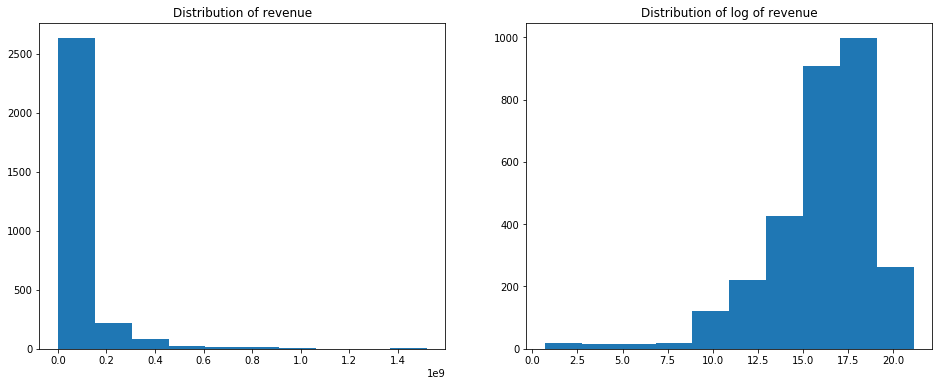

In [125]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [126]:
train.head(2)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,HasCollection,num_genres,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,...,Production Design,Costume Design,Writer,Set Decoration,Makeup Artist,Sound Re-Recording Mixer,Camera Operator,Script Supervisor,Hairstylist,Visual Effects Supervisor,Sound Effects Editor,Stunts,Still Photographer,Music Editor,Visual Effects Producer,Dialogue Editor,Stunt Coordinator,Co-Producer,Supervising Sound Editor,Production,Sound,Art,Crew,Writing,Costume & Make-Up,Camera,Directing,Editing,Visual Effects,Lighting,Actors,HasHomepage,original_langauge_code,real_release_date,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter
0,1,14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,7,2015-02-20,2015,4,2,8,20,1
1,2,40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,7,2004-08-06,2004,4,8,32,6,3


In [127]:
drop_columns = ['id', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies',
               'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'real_release_date',
               'cast_name', 'cast_character', 'cast_gender', 'crew_name', 'crew_job', 'crew_department', 'crew_gender', 'all_genres']
train['runtime'].fillna(train['runtime'].median(), inplace=True)
test['runtime'].fillna(train['runtime'].median(), inplace=True)

train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)

In [128]:
print(train.dtypes)

budget                         int64
popularity                   float64
runtime                      float64
revenue                        int64
HasCollection                  int64
num_genres                     int64
Drama                          int64
Comedy                         int64
Thriller                       int64
Action                         int64
Romance                        int64
Crime                          int64
Adventure                      int64
Horror                         int64
Science Fiction                int64
Family                         int64
Fantasy                        int64
Mystery                        int64
Animation                      int64
History                        int64
Music                          int64
War                            int64
Documentary                    int64
Western                        int64
Foreign                        int64
TV Movie                       int64
all_genres_Drama               int64
a

## Modeling

In [129]:
X = train.drop('revenue', axis=1)
y = train['revenue']
sub = pd.read_csv('../input/sample_submission.csv')
print(X.shape, y.shape, test.shape)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(3000, 322) (3000,) (4398, 322)
(2700, 322) (2700,) (300, 322) (300,)


### 1. XGBoosting

In [130]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


def modelfit(alg, X_train, y_train, X_valid, y_valid, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_valid)
      
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4f" % rmsle(y_valid.values, dtrain_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[0:20]
    
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
RMSE : 2.4513


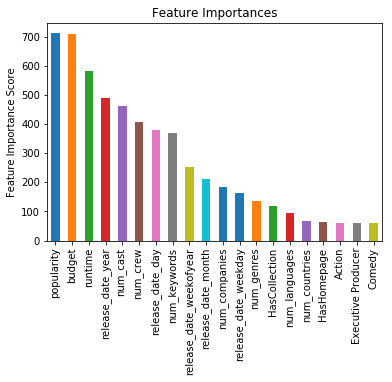

In [150]:
#Choose all predictors except target & IDcols
import xgboost as xgb
xgb1 = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=140,
    max_depth=4,
    min_child_weight=4,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

modelfit(xgb1, X_train, y_train, X_valid, y_valid)

#from sklearn.metrics import make_scorer
#score = make_scorer(rmsle, greater_is_better=False)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='neg_mean_squared_error',
                                                  n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Note: Thus, we will max_depth=3, min_child_weight=5 as our best parameters!

param_test2 = {
 'max_depth': [2,3,4],
 'min_child_weight': [4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=3,
                                                  min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test2, scoring='neg_mean_squared_error',
                                                  n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

Note: This time we select max_depth=4, min_child_weight=4 as our best parameters!

param_test3 = {
 'gamma':[i/100.0 for i in range(0,20, 3)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=4,
                                                  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test3, scoring='neg_mean_squared_error',
                                                  n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

modelfit(gsearch3.best_estimator_,  X_train, y_train, X_valid, y_valid)

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=140, max_depth=4,
                                                  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test4, scoring='neg_mean_squared_error',
                                                  n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

modelfit(gsearch4.best_estimator_,  X_train, y_train, X_valid, y_valid)

param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=140, max_depth=4,
                                                  min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.7,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test5, scoring='neg_mean_squared_error',
                                                  n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

param_test6 = {
 'reg_alpha':[0, 0.01, 0.05, 0.1, 0.5]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=140, max_depth=4,
                                                  min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.7,nthread=4, 
                                                  scale_pos_weight=1, seed=27), param_grid = param_test6, scoring='neg_mean_squared_error',
                                                  n_jobs=-1,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

modelfit(gsearch6.best_estimator_,  X_train, y_train, X_valid, y_valid)

In [ ]:
final = xgb.XGBRegressor(learning_rate =0.003, n_estimators=170, max_depth=4,
                                                  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, 
                                                  scale_pos_weight=1, seed=27)
final.fit(X,y,eval_metric='rmse')
xgb_y_pred = final.predict(test)
sub['revenue'] = xgb_y_pred
sub.to_csv("XGBoost_advance.csv", index=False)

### 2. XGB in another way

In [ ]:
'''
# XGBoosting
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X,y)
XG_y_pred = xg_reg.predict(test)
sub['revenue'] = XG_y_pred
sub.to_csv("XG.csv", index=False)
print(X.shape, y.shape, test.shape)
'''

In [ ]:
'''
import xgboost as xgb
xgb_params = {'objective': 'reg:linear'}
params = {'objective': 'reg:linear', 
    'eta': 0.01, 
    'max_depth': 6, 
    'subsample': 0.6, 
    'colsample_bytree': 0.7,  
    'eval_metric': 'rmse', 
    'seed': 2019, 
    'silent': True,
}

train_data = xgb.DMatrix(X, label=y)
#watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
xgb_model = xgb.train(dtrain=train_data, num_boost_round=200, params=params)
xgb_y_pred = xgb_model.predict(xgb.DMatrix(test))

sub['revenue'] = xgb_y_pred
sub.to_csv("XGBoost.csv", index=False)
'''

### 3. LGBoosting

In [ ]:
# LGB
import lightgbm as lgb
#params = {'objective': 'regression'}
params = {'objective':'regression',
    'num_leaves' : 30,
    'min_data_in_leaf' : 20,
    'max_depth' : 9,
    'learning_rate': 0.004,
    #'min_child_samples':100,
    'feature_fraction':0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    'lambda_l1': 0.2,
    "bagging_seed": 2019,
    "metric": 'rmse',
    #'subsample':.8, 
    #'colsample_bytree':.9,
    "random_state" : 2019,
    "verbosity": -1
}
model1 = lgb.LGBMRegressor(**params, n_estimators = 3000)
model1.fit(X_train.values, y_train.values, 
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

LGB_y_pred = model1.predict(test, num_iteration=model1.best_iteration_)
sub['revenue'] = LGB_y_pred
sub.to_csv("LGB.csv", index=False)
print(LGB_y_pred[0:10].astype(int))

Note: Hidden Linear Regression Code

<!---
from sklearn.linear_model import LinearRegression
# LinearRegression
LR = LinearRegression()
LR.fit(X,y)
LR_y_pred = LR.predict(test)
sub['revenue'] = LR_y_pred
sub.to_csv("LR.csv", index=False)
--->

Note: Hidden AdaBoostRegressor Code

<!---
# AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
ABR = AdaBoostRegressor()
tuned_parameters = [{'n_estimators': [10, 25, 50, 75, 100], 'learning_rate': [0.1, 0.3, 1, 3],
                     'loss': ['linear','square']}]
#k = cross_validate(ABR, X, y, scoring='neg_mean_squared_error',cv=10)
#, 'square', 'exponential'
clf = GridSearchCV(AdaBoostRegressor(), tuned_parameters, cv=5,
                       scoring='mean_squared_error')
clf.fit(X, y)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
ABR_y_pred = clf.predict(test)
print()
sub['revenue'] = ABR_y_pred
sub.to_csv("ABR.csv", index=False)
--->

In [ ]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
GDB = GradientBoostingRegressor().fit(X,y)
GDB_y_pred = GDB.predict(test)

sub['revenue'] = GDB_y_pred
sub.to_csv("GDB.csv", index=False)

In [ ]:
###### BaggingRegressor
from sklearn.ensemble import BaggingRegressor
BR = BaggingRegressor().fit(X,y)
BR_y_pred = BR.predict(test)
sub['revenue'] = BR_y_pred
sub.to_csv("BR.csv", index=False)